In [14]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from skimage.color import label2rgb
from tifffile import imread
from os import listdir

from yoeo.main import get_dv2_model, get_upsampler_and_expr, get_hr_feats, get_lr_feats, convert_image, closest_crop
from yoeo.utils import to_numpy

from interactive_seg_backend import featurise_
from interactive_seg_backend.configs import FeatureConfig, TrainingConfig, CRFParams
from interactive_seg_backend.classifiers.base import Classifier
from interactive_seg_backend.file_handling import load_labels, load_image
from interactive_seg_backend.core import train, get_training_data, shuffle_sample_training_data, get_model
from interactive_seg_backend.core import apply_
from interactive_seg_backend.main import apply
from interactive_seg_backend.utils import class_avg_miou


from typing import Literal

SEED = 10672
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda:1"

In [2]:
cmap = [
            "#fafafa",
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
        ]
color_list = [[255, 255, 255], [31, 119, 180], [255, 127, 14], [44, 160, 44], [255, 0, 0]]
COLORS = np.array(color_list) / 255.0

In [3]:
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_full_fit_reg.pth"
cfg_path = "../yoeo/models/configs/combined_no_shift.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main


In [4]:
PATH = "fig_data/is_benchmark"
AllowedDatasets = Literal["Cu_ore_RLM", "Ni_superalloy_SEM", "T_cell_TEM"]
dataset: tuple[AllowedDatasets, ...] = ("Cu_ore_RLM", "Ni_superalloy_SEM", "T_cell_TEM")

TRAIN_IMG_FNAMES: dict[AllowedDatasets, list[str]] = {"Cu_ore_RLM": ["001", "028", "049", "068"], 
                                                      "Ni_superalloy_SEM": ["000", "001", "005", "007"], 
                                                      "T_cell_TEM": ["000", "027", "021", "105"]
                                                      }

In [5]:
def get_deep_feats(img: Image.Image, K: int =32, existing_pca: object | None = None) -> np.ndarray:
    hr_feats = get_hr_feats(img, dv2, upsampler, DEVICE, n_ch_in=expr.n_ch_in, existing_pca=existing_pca)
    hr_feats_np = to_numpy(hr_feats)
    hr_feats_np = hr_feats_np.transpose((1, 2, 0))[:, :, :K]
    return hr_feats_np

def train_model_over_images(dataset: AllowedDatasets, train_cfg: TrainingConfig) -> tuple[Classifier, object]:
    features, labels = [], []
    train_fnames = TRAIN_IMG_FNAMES[dataset]

    pca = None
    if train_cfg.add_dino_features:
        imgs = []
        for fname in train_fnames:
            img_path = f"{PATH}/{dataset}/images/{fname}.tif"
            arr = load_image(img_path)
            img = Image.fromarray(arr).convert('RGB')
            tr = closest_crop(img.height, img.width)
            tensor = convert_image(img, tr, device_str=DEVICE)
            imgs.append(tensor)

        _, pca = get_lr_feats(dv2, imgs, fit3d=True)


    for fname in train_fnames:
        img_path = f"{PATH}/{dataset}/images/{fname}.tif"
        labels_path = f"{PATH}/{dataset}/labels/{fname}.tif"

        img_arr = load_image(img_path)
        label_arr = load_labels(labels_path)

        feats = featurise_(img_arr, train_cfg.feature_config)
        if train_cfg.add_dino_features:
            img = Image.fromarray(img_arr).convert('RGB')
            deep_feats = get_deep_feats(img, 32, pca)
            feats = np.concatenate((feats, deep_feats), axis=-1)

        features.append(feats)
        labels.append(label_arr)

    print('Finished featurising')
    fit, target = get_training_data(features, labels)
    fit, target = shuffle_sample_training_data(
        fit, target, train_cfg.shuffle_data, train_cfg.n_samples
    )
    model = get_model(
        train_cfg.classifier, train_cfg.classifier_params, train_cfg.use_gpu
    )
    model = train(model, fit, target, None)
    return model, pca

In [6]:
def apply_model_over_images(dataset: AllowedDatasets, train_cfg: TrainingConfig, model: Classifier, verbose: bool=False, early_cutoff_n: int = -1, existing_pca: object | None = None) -> dict[str, np.ndarray]:
    preds: dict[str, np.ndarray] = {}
    img_fnames = sorted(listdir(f"{PATH}/{dataset}/images"))
    N_imgs = len(img_fnames)

    selected_imgs = img_fnames if early_cutoff_n <= 0 else img_fnames[:early_cutoff_n]

    for i, fname in enumerate(selected_imgs):
        if verbose and i % 10 == 0:
            print(f"[{i:02d}/{N_imgs}] - {fname}")
        img_path = f"{PATH}/{dataset}/images/{fname}"
        img_arr = load_image(img_path)

        feats = featurise_(img_arr, train_cfg.feature_config)
        if train_cfg.add_dino_features:
            img = Image.fromarray(img_arr).convert('RGB')
            deep_feats = get_deep_feats(img, 32, existing_pca=existing_pca)
            feats = np.concatenate((feats, deep_feats), axis=-1)

        pred, _ = apply(model, feats, train_cfg, image=img_arr) #apply_(model, feats)
        preds[fname] = pred
    return preds

In [7]:
def eval_preds(dataset: AllowedDatasets, preds: dict[str, np.ndarray]) -> float:
    mious: list[float] = []
    seg_fnames = sorted(listdir(f"{PATH}/{dataset}/segmentations"))
    for i, fname in enumerate(seg_fnames):
        seg_path = f"{PATH}/{dataset}/segmentations/{fname}"
        pred = preds[fname]
        ground_truth = load_labels(seg_path)
        miou = class_avg_miou(pred, ground_truth)
        mious.append(miou)
    return np.mean(mious)

In [8]:
chosen_dataset: AllowedDatasets = "Ni_superalloy_SEM"

In [19]:
feat_cfg = FeatureConfig()

classical_train_cfg = TrainingConfig(feat_cfg, preprocessing=("equalize",), n_samples=-1, add_dino_features=False, classifier='xgb', classifier_params = {"class_weight": "balanced"},)
classical_model, _ = train_model_over_images(chosen_dataset, classical_train_cfg)

deep_train_cfg = TrainingConfig(feat_cfg, preprocessing=("equalize",), n_samples=-1, add_dino_features=True, classifier='xgb', classifier_params = {"class_weight": "balanced"},)
deep_model, pca = train_model_over_images(chosen_dataset, deep_train_cfg)

Finished featurising
Finished featurising


In [20]:
classical_preds = apply_model_over_images(chosen_dataset, classical_train_cfg, classical_model, verbose=True)
deep_preds = apply_model_over_images(chosen_dataset, deep_train_cfg, deep_model, verbose=True, existing_pca=pca)

[00/23] - 000.tif
[10/23] - 010.tif
[20/23] - 020.tif
[00/23] - 000.tif
[10/23] - 010.tif
[20/23] - 020.tif


In [21]:
miou_classical = eval_preds(chosen_dataset, classical_preds)
miou_deep = eval_preds(chosen_dataset, deep_preds)

print(f"mIoU_classical: {miou_classical} vs mIoU_deep: {miou_deep}")

mIoU_classical: 0.5427500946383244 vs mIoU_deep: 0.6945920377635636


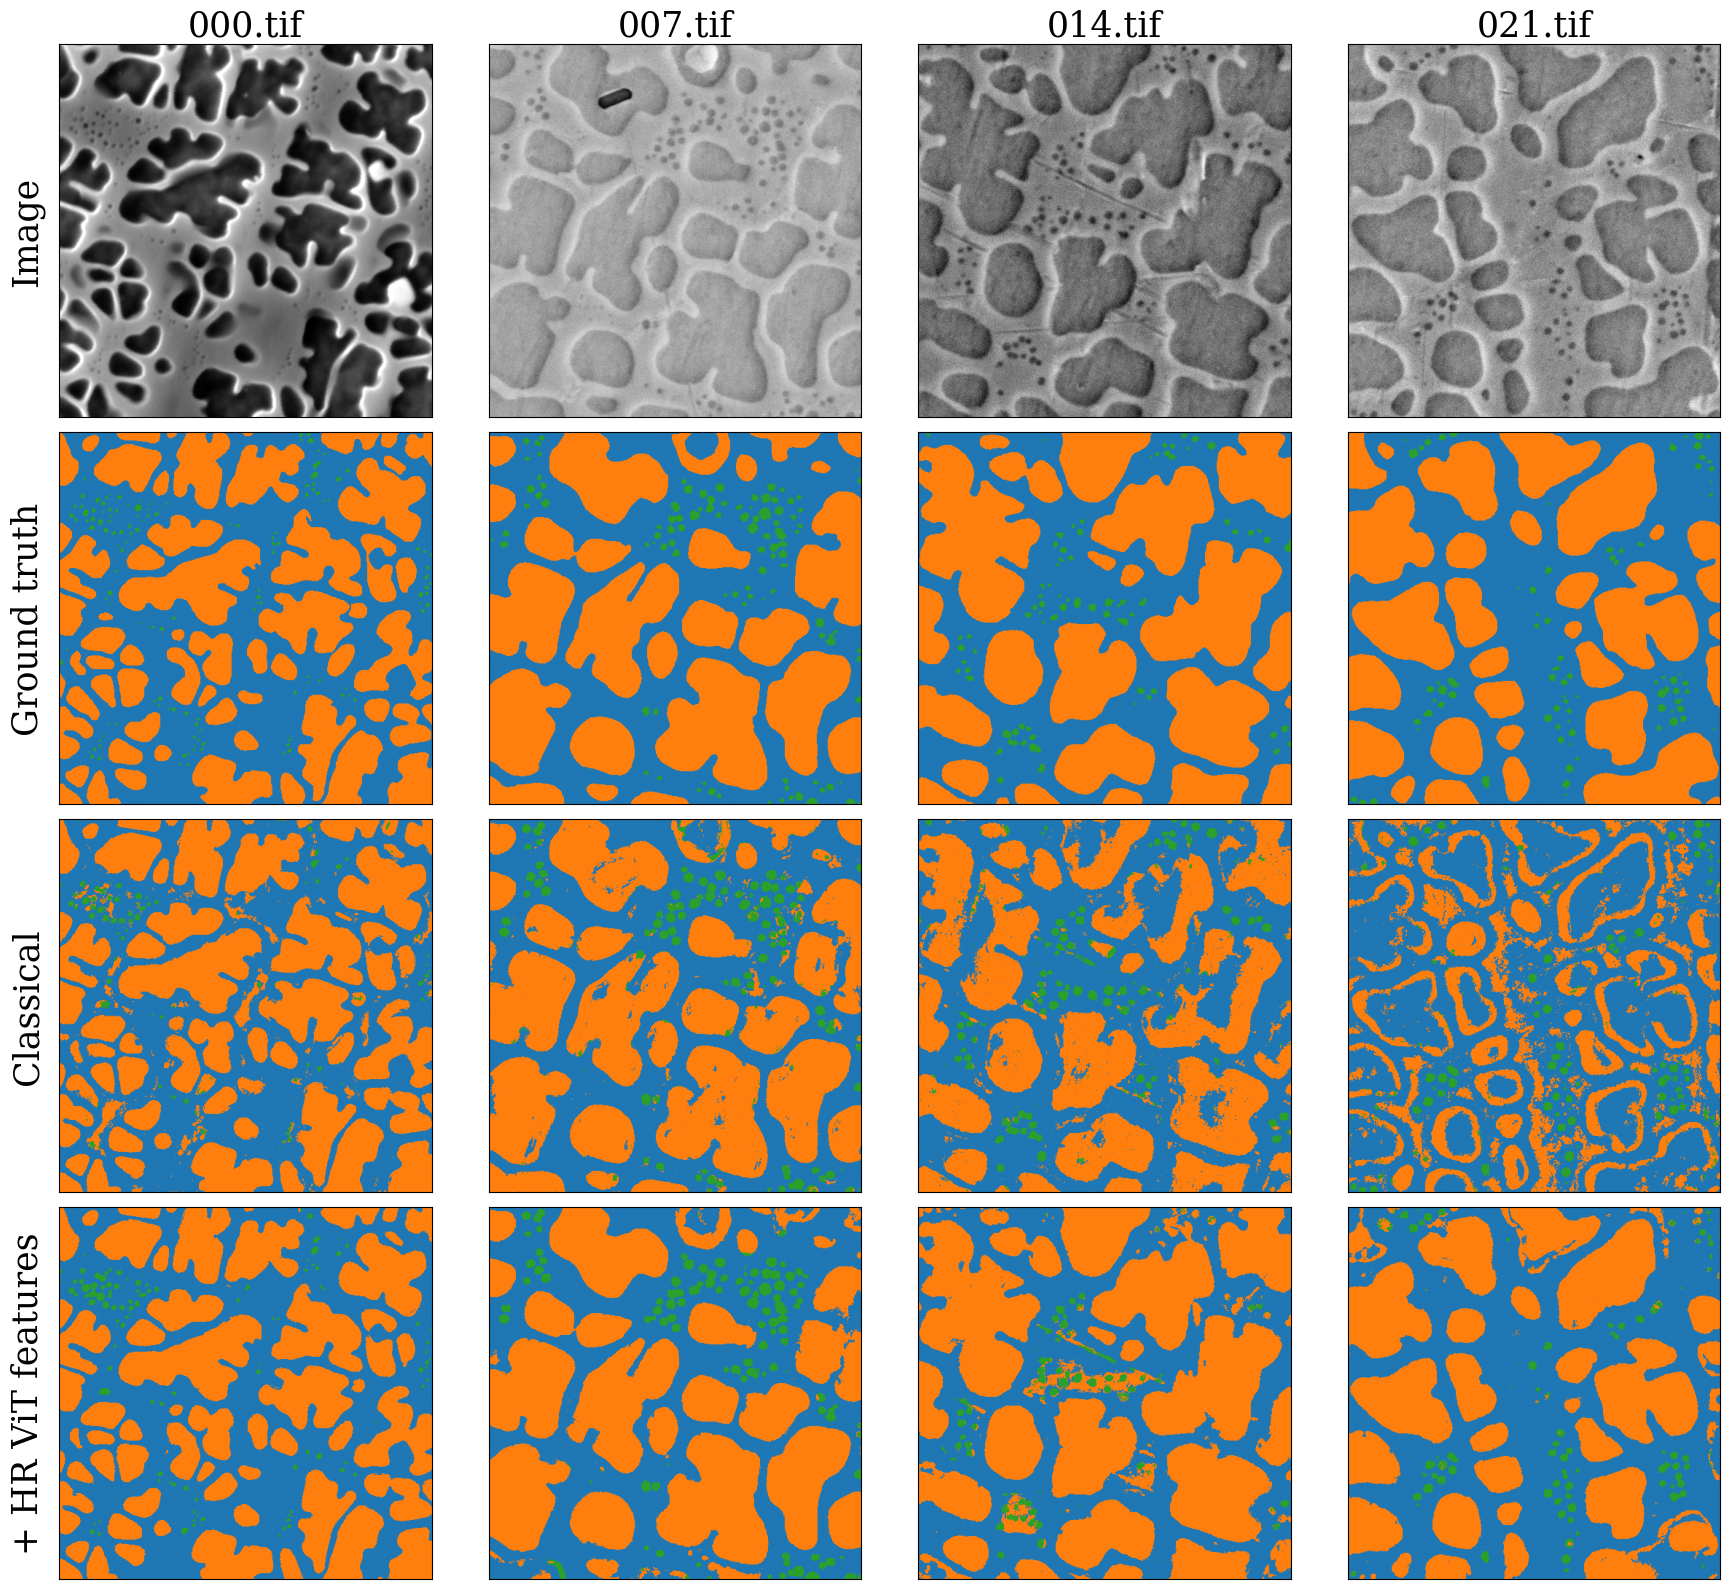

In [23]:
TITLE_FS = 25
LABEL_FS = 23
TICK_FS = 21

img_paths = sorted(listdir(f"{PATH}/{chosen_dataset}/images"))[::7]

n_samples = len(img_paths)
fig, axs = plt.subplots(nrows=4, ncols=n_samples)
plt.rcParams["font.family"] = "serif"
fig.set_size_inches((18, 16))


for i, img_fname in enumerate(img_paths):
    img = imread(f"{PATH}/{chosen_dataset}/images/{img_fname}")
    gt_seg = imread(f"{PATH}/{chosen_dataset}/segmentations/{img_fname}")

    classical_pred = classical_preds[img_fname]
    deep_pred = deep_preds[img_fname]

    ax0, ax1, ax2, ax3 = axs[: ,i]
    ax0.imshow(img, cmap='binary_r')
    ax1.imshow(label2rgb(gt_seg, colors=COLORS[1:]))
    ax2.imshow(label2rgb(classical_pred + 1, colors=COLORS[1:]))
    ax3.imshow(label2rgb(deep_pred + 1, colors=COLORS[1:]))

    if i == 0:
        ax0.set_ylabel('Image', fontsize=TITLE_FS)
        ax1.set_ylabel('Ground truth', fontsize=TITLE_FS)
        ax2.set_ylabel('Classical', fontsize=TITLE_FS)
        ax3.set_ylabel('+ HR ViT features', fontsize=TITLE_FS)
    
    ax0.set_title(img_fname, fontsize=TITLE_FS)

    for ax in (ax0, ax1, ax2, ax3):
        ax.tick_params(which="both", bottom=False, top=False, left=False, right=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.tight_layout()